In [2]:
import torch
import torchvision
import numpy as np
import math

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from improved_diffusion.script_util import (
    create_model_and_diffusion
)

from tqdm.notebook import tqdm, trange

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda:0


# Display functions

In [3]:
# We will work with PyTorch images with color values in $[-1,1]$ and the usual additional batch dimension.
# Images will have size 1x3x128x128 in PyTorch.

def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  t = 0.5+0.5*t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

# Load DDPM Unet

In [4]:
config = {
    'image_size': 128,
    'num_channels': 128,
    'num_res_blocks': 3,
    'diffusion_steps': 1000,
    'noise_schedule': 'cosine',
    'num_heads': 4,
    'num_heads_upsample': -1,
    'attention_resolutions': "16,8",
    'dropout': 0.0,
    'learn_sigma': False,
    'sigma_small': False,
    'class_cond': False,
    'timestep_respacing': "",
    'use_kl': False,
    'predict_xstart': False,
    'rescale_timesteps': True,
    'rescale_learned_sigmas': True,
    'use_checkpoint': False,
    'use_scale_shift_norm': True,
}

In [5]:
model, diffusion = create_model_and_diffusion(
    **config
)
model.load_state_dict(torch.load("/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/models/model-152k-fits/ema_0.9999_152000.pt", map_location='cpu'))
model = model.to(device)
# use in eval mode:
model.eval();

In [6]:
# Print the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in the model: {count_parameters(model)}")

Number of parameters in the model: 158790147


In [7]:
model.forward;

# DDPM class

In [8]:
# Function to define the beta scheduling

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                    produces the cumulative product of (1-beta) up to that
                    part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                    prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

In [9]:
class DDPM:
  def __init__(self, model=model, DDIM=False):
    self.num_diffusion_timesteps = 1000
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    beta_start = 0.0001
    beta_end = 0.02
    #self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps, dtype=np.float64)   # linear scheduling
    self.betas = betas_for_alpha_bar(
            self.num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )   # cosine scheduling
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.model = model
    self.imgshape = (1,3,128,128)
    self.DDIM = DDIM

  def get_eps_from_model(self, x, t):
    # the model outputs:
    # - an estimation of the noise eps (channels 0 to 2)
    # - learnt variances for the posterior  (channels 3 to 5)
    # (see Improved Denoising Diffusion Probabilistic Models
    # by Alex Nichol, Prafulla Dhariwal
    # for the parameterization)
    # We discard the second part of the output for this practice session.
    model_output = self.model(x, torch.tensor(t, device=device).unsqueeze(0))
    model_output = model_output[:,:3,:,:]
    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def sample(self, show_steps=True):
    with torch.no_grad():  # avoid backprop wrt model parameters
        xt = torch.randn(self.imgshape, device=device)  # initialize x_t for t=T
        for i, t in enumerate(self.reversed_time_steps):
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alphas_cumprod[t]
            alpha_bar_prev_t = self.alphas_cumprod_prev[t]

            eps = self.get_eps_from_model(xt, t)

            if self.DDIM:
                # Using the deterministic path for DDIM
                x0_pred = self.predict_xstart_from_eps(xt, eps, t)
                # Update xt using the deterministic DDIM update
                if t > 0:
                    xt = np.sqrt(alpha_bar_prev_t) * x0_pred + np.sqrt(1 - alpha_bar_prev_t) * eps
            else:
                # Standard DDPM update with noise
                z = torch.randn(self.imgshape, device=device) if t > 1 else torch.zeros(self.imgshape, device=device)
                sigma_t = np.sqrt(self.betas[t])
                xt = 1 / np.sqrt(alpha_t) * (xt - (1 - alpha_t) / np.sqrt(1 - alpha_bar_t) * eps) + sigma_t * z

            if show_steps and t % 100 == 0:
                print('Iteration:', t)
                pilimg = display_as_pilimg(torch.cat((xt, self.predict_xstart_from_eps(xt, eps, t)), dim=3)[:,:3]*2 - 1)

    return xt

  
  def posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):
      if vis_y is None:
          vis_y = y

      # Initialize xt for t=T
      x = torch.randn(self.imgshape, device=device)
      x.requires_grad = True

      for t in tqdm(self.reversed_time_steps[1:]):  # Start from the last timestep

          alpha_t = self.alphas[t]
          alpha_bar_t = self.alphas_cumprod[t]
          alpha_bar_tm1 = self.alphas_cumprod_prev[t]

          eps = self.get_eps_from_model(x, t)
          xhat = self.predict_xstart_from_eps(x, eps, t)

          if self.DDIM:
            # Using DDIM, update x deterministically
            if t > 0:
                x_prime = np.sqrt(alpha_bar_tm1) * xhat + np.sqrt(1 - alpha_bar_tm1) * eps
            else:
                x_prime = xhat  # At the last step, we converge to the deterministic prediction

          else:
            beta_t = self.betas[t]
            sigma_t = np.sqrt(beta_t)

            z = torch.randn(self.imgshape, device=device)

            x_prime = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x
            x_prime += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat
            x_prime += sigma_t*z

          df_term = torch.sum(((y+1)/2-linear_operator(xhat))**2)
          grad = torch.autograd.grad(df_term, x)[0]
          zeta = 1 / torch.sqrt(df_term)

          x = x_prime - zeta * grad

          if show_steps and (t)%100==0:
            print('Iteration :', t)
            if t==0:
              pilimg = display_as_pilimg(torch.cat((x*2 - 1, y, x_true), dim=3))
            else:
              pilimg = display_as_pilimg(torch.cat((x*2 - 1, xhat*2 - 1, y, x_true), dim=3))
          else:
            if t==0:
              pilimg = display_as_pilimg(torch.cat((x*2 - 1, y, x_true), dim=3))

      return x


  def posterior_sampling_deblending(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):
      if vis_y is None:
          vis_y = y

      # Initialize xt for t=T
      x1 = torch.randn(self.imgshape, device=device)
      x1.requires_grad = True

      x2 = torch.randn(self.imgshape, device=device)
      x2.requires_grad = True

      for t in tqdm(self.reversed_time_steps[1:]):  # Start from the last timestep

          alpha_t = self.alphas[t]
          alpha_bar_t = self.alphas_cumprod[t]
          alpha_bar_tm1 = self.alphas_cumprod_prev[t]

          beta_t = self.betas[t]
          sigma_t = np.sqrt(beta_t)

          # First diffusion
          eps1 = self.get_eps_from_model(x1, t)
          xhat1 = self.predict_xstart_from_eps(x1, eps1, t)          

          z1 = torch.randn(self.imgshape, device=device)

          x_prime1 = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x1
          x_prime1 += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat1
          x_prime1 += sigma_t*z1

          # Second diffusion
          eps2 = self.get_eps_from_model(x2, t)
          xhat2 = self.predict_xstart_from_eps(x2, eps2, t)          

          z2 = torch.randn(self.imgshape, device=device)

          x_prime2 = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x2
          x_prime2 += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat2
          x_prime2 += sigma_t*z2

          # Update first image
          df_term = torch.sum(((y+1)/2-linear_operator(xhat1, xhat2))**2)
          zeta = 1 / torch.sqrt(df_term)

          grad1 = torch.autograd.grad(df_term, x1)[0]
          
          x1 = x_prime1 - zeta * grad1

          # Update second image
          df_term2 = torch.sum(((y+1)/2-linear_operator(xhat1, xhat2))**2)
          zeta = 1 / torch.sqrt(df_term2)
          grad2 = torch.autograd.grad(df_term2, x2)[0]

          x2 = x_prime2 - zeta * grad2

          blended = linear_operator(xhat1, xhat2)

          if show_steps and (t)%100==0:
            print('Iteration :', t)
            if t==0:
              pilimg = display_as_pilimg(torch.cat((y, blended*2 - 1), dim=3))
              pilimg = display_as_pilimg(torch.cat((x1*2 - 1, x2*2 - 1), dim=3))
            else:
              pilimg = display_as_pilimg(torch.cat((y, blended*2 - 1), dim=3))
              pilimg = display_as_pilimg(torch.cat((x1*2 - 1, xhat1*2 - 1, x2*2 - 1, xhat2*2 - 1), dim=3))
          else:
            if t==0:
              pilimg = display_as_pilimg(torch.cat((y, blended*2 - 1), dim=3))
              pilimg = display_as_pilimg(torch.cat((x1*2 - 1, x2*2 - 1), dim=3))

      return x1, x2

ddpm = DDPM(DDIM=False)

# Conditional sampling for imaging inverse problems

In [10]:
# Peak signal to Noise ration

def mypsnr(x,y):
  error = torch.mean((x-y)**2).item()
  psnr = 10*np.log10(2**2/error)
  return(psnr)

## Deblending

cuda:0
original image 00012.png


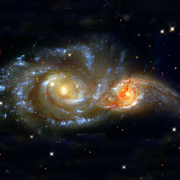

In [11]:
h = 128
w = 128

idx = 12
x_true_pil = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/test_deblending.png').convert('RGB')

x_true = pilimg_to_tensor(x_true_pil)
print(x_true.device)
print("original image", str(idx).zfill(5)+'.png')
display_as_pilimg(x_true[:3])

y = x_true

### Create an artificially blended TNG image

/gpfswork/rech/tkc/uwa51yi/.venv/lib64/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


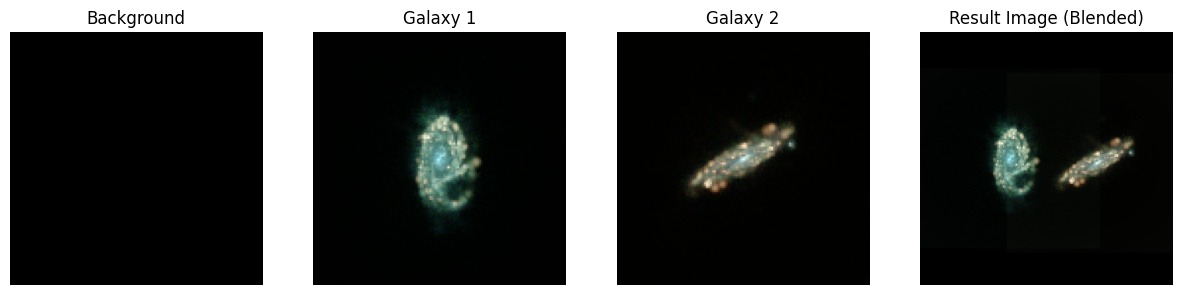

In [12]:
import torch
import matplotlib.pyplot as plt

def apply_gaussian_filter(tensor, sigma=8):
    """
    Apply a Gaussian filter to create a brightness effect.
    
    Args:
        tensor (torch.Tensor): A [1, 3, 128, 128] tensor.
        sigma (int): The standard deviation of the Gaussian filter.
    
    Returns:
        torch.Tensor: The tensor with the brightness effect applied.
    """
    channels, height, width = tensor.shape[1:]
    x = torch.linspace(-1, 1, height)
    y = torch.linspace(-1, 1, width)
    xx, yy = torch.meshgrid(x, y)
    gaussian = torch.exp(-((xx**2 + yy**2) / (2.0 * sigma**2)))
    gaussian = gaussian.unsqueeze(0).repeat(channels, 1, 1).unsqueeze(0).to(tensor.device)
    return tensor + (1 - gaussian)

def linear_operator(small_image1, small_image2, big_image=torch.zeros(1, 3, 180, 180).to(device), center_position1=(90, 64), center_position2=(93, 126)):
    """
    Place two 128x128 3-channel tensors (small_image1 and small_image2) at specified positions in a 152x152 3-channel tensor (big_image),
    sum the two images and divide by 2 to average them.
    
    Args:
        small_image1 (torch.Tensor): A [1, 3, 128, 128] tensor.
        small_image2 (torch.Tensor): A [1, 3, 128, 128] tensor.
        big_image (torch.Tensor): A [1, 3, 152, 152] tensor.
        center_position1 (tuple): The (x, y) position of the center of the first small image in the big image.
        center_position2 (tuple): The (x, y) position of the center of the second small image in the big image.
    
    Returns:
        torch.Tensor: The modified big_image with the small_image1 and small_image2 placed at the specified positions.
    """
    big_image_copy = big_image.clone()

    def place_image(small_image, big_image, center_position):
        x_center, y_center = center_position

        # Apply Gaussian filter to add brightness effect
        small_image = apply_gaussian_filter(small_image)

        # Calculate the top-left corner position of the small image in the big image
        x_start = x_center - small_image.shape[2] // 2
        y_start = y_center - small_image.shape[3] // 2

        # Ensure the coordinates are within bounds
        x_end = min(x_start + small_image.shape[2], big_image.shape[2])
        y_end = min(y_start + small_image.shape[3], big_image.shape[3])
        x_start = max(x_start, 0)
        y_start = max(y_start, 0)

        # Calculate the valid region in the small image to avoid out-of-bounds indexing
        valid_x_start = max(-x_start, 0)
        valid_y_start = max(-y_start, 0)
        valid_x_end = min(big_image.shape[2] - x_start, small_image.shape[2])
        valid_y_end = min(big_image.shape[3] - y_start, small_image.shape[3])

        # Place the small image in the big image
        big_image[:, :, x_start:x_end, y_start:y_end] += small_image[:, :, valid_x_start:valid_x_end, valid_y_start:valid_y_end]
        
        return big_image

    # Place both small images in the big image
    big_image_copy = place_image(small_image1, big_image_copy, center_position1)
    big_image_copy = place_image(small_image2, big_image_copy, center_position2)

    #big_image_copy = torch.clamp(big_image_copy, 0, 1)

    return big_image_copy

def plot_image(tensor, title):
    img = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Create example images
small_image1 = torch.ones(1, 3, 128, 128)  # [1, 3, 128, 128] tensor filled with ones (white)
small_image2 = torch.ones(1, 3, 128, 128)  # [1, 3, 128, 128] tensor filled with ones (white)
big_image = torch.zeros(1, 3, 180, 180)   # [1, 3, 152, 152] tensor filled with zeros (black)

# Create small images filled with different colors for easier visualization
small_image1[0, 0, :, :] = 1  # Red channel
small_image1[0, 1, :, :] = 0  # Green channel
small_image1[0, 2, :, :] = 0  # Blue channel

small_image2[0, 0, :, :] = 0  # Red channel
small_image2[0, 1, :, :] = 1  # Green channel
small_image2[0, 2, :, :] = 0  # Blue channel


x1_pil = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/datasets/dummy2_z=0.1/TNG_test_stretched/00011.png').convert('RGB')

x1 = (pilimg_to_tensor(x1_pil)+1)/2

x2_pil = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/datasets/dummy2_z=0.1/TNG_test_stretched/00019.png').convert('RGB')

x2 = (pilimg_to_tensor(x2_pil)+1)/2


# Apply the linear operator
result_image = linear_operator(x1.to(device), x2.to(device), big_image.to(device))


# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plot_image(big_image, "Background")

plt.subplot(1, 4, 2)
plot_image(x1, "Galaxy 1")

plt.subplot(1, 4, 3)
plot_image(x2, "Galaxy 2")

plt.subplot(1, 4, 4)
plot_image(result_image, "Result Image (Blended)")

plt.show()

### Posterior Sampling

  0%|          | 0/999 [00:00<?, ?it/s]

Iteration : 900


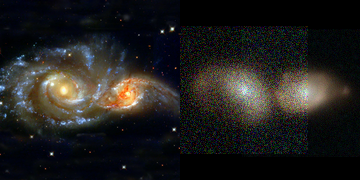

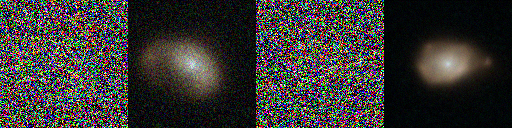

Iteration : 800


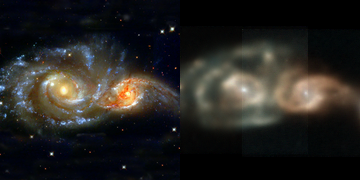

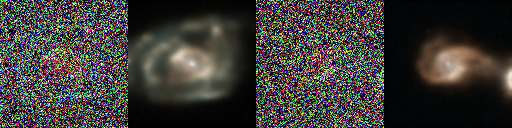

Iteration : 700


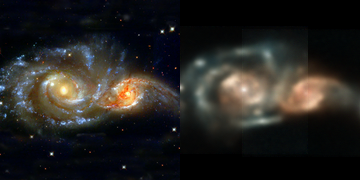

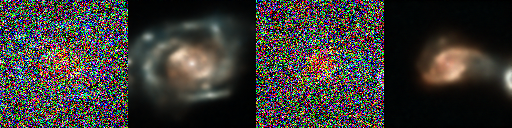

Iteration : 600


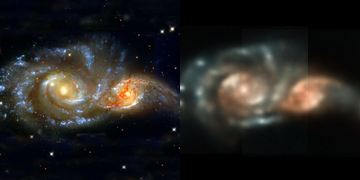

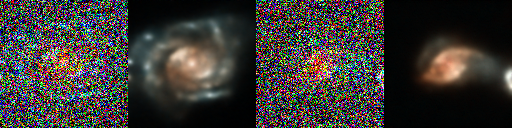

Iteration : 500


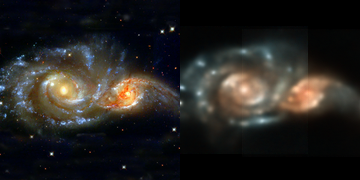

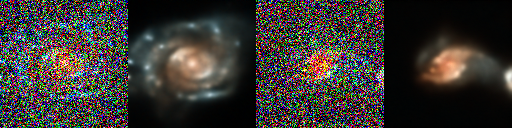

Iteration : 400


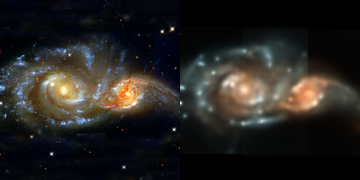

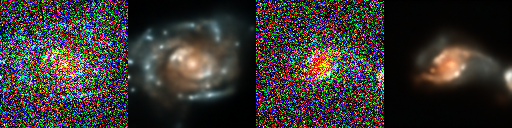

Iteration : 300


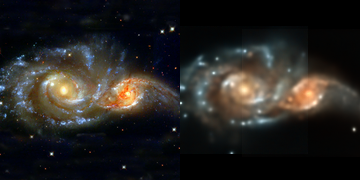

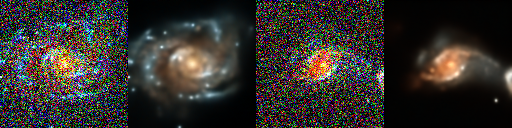

Iteration : 200


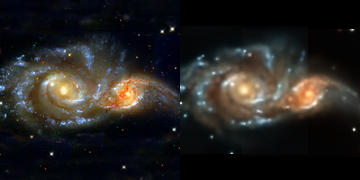

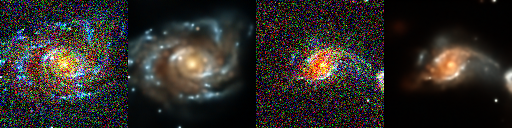

Iteration : 100


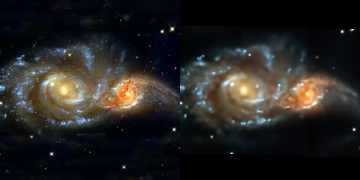

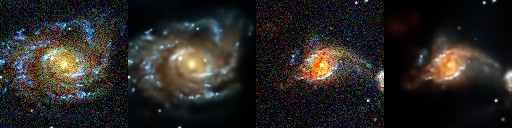

Iteration : 0


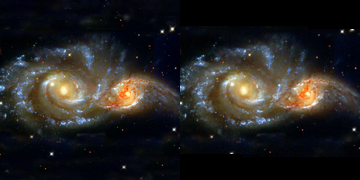

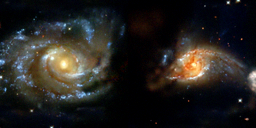

In [13]:
x1, x2 = ddpm.posterior_sampling_deblending(linear_operator, y, x_true=x_true, show_steps=True);